In [5]:
# Cell 1: Import all necessary libraries
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning libraries
import tensorflow as tf
import keras
from keras import layers, models
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Image processing
from PIL import Image

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

Available genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

=== Audio Files ===
Total audio files: 1000
Files per genre:
  blues: 100 files
  classical: 100 files
  country: 100 files
  disco: 100 files
  hiphop: 100 files
  jazz: 100 files
  metal: 100 files
  pop: 100 files
  reggae: 100 files
  rock: 100 files

=== Image Files ===
Total image files: 999
Files per genre:
  blues: 100 files
  classical: 100 files
  country: 100 files
  disco: 100 files
  hiphop: 100 files
  jazz: 99 files
  metal: 100 files
  pop: 100 files
  reggae: 100 files
  rock: 100 files

=== Combined Dataset ===
Total files: 1999
Audio files: 1000
Image files: 999

First few audio files:
                               file_path  label file_type
0  genres_original\blues\blues.00000.wav  blues     audio
1  genres_original\blues\blues.00001.wav  blues     audio
2  genres_original\blues\blues.00002.wav  blues     audio
3  genres_original\blues\blues.00003.wav  

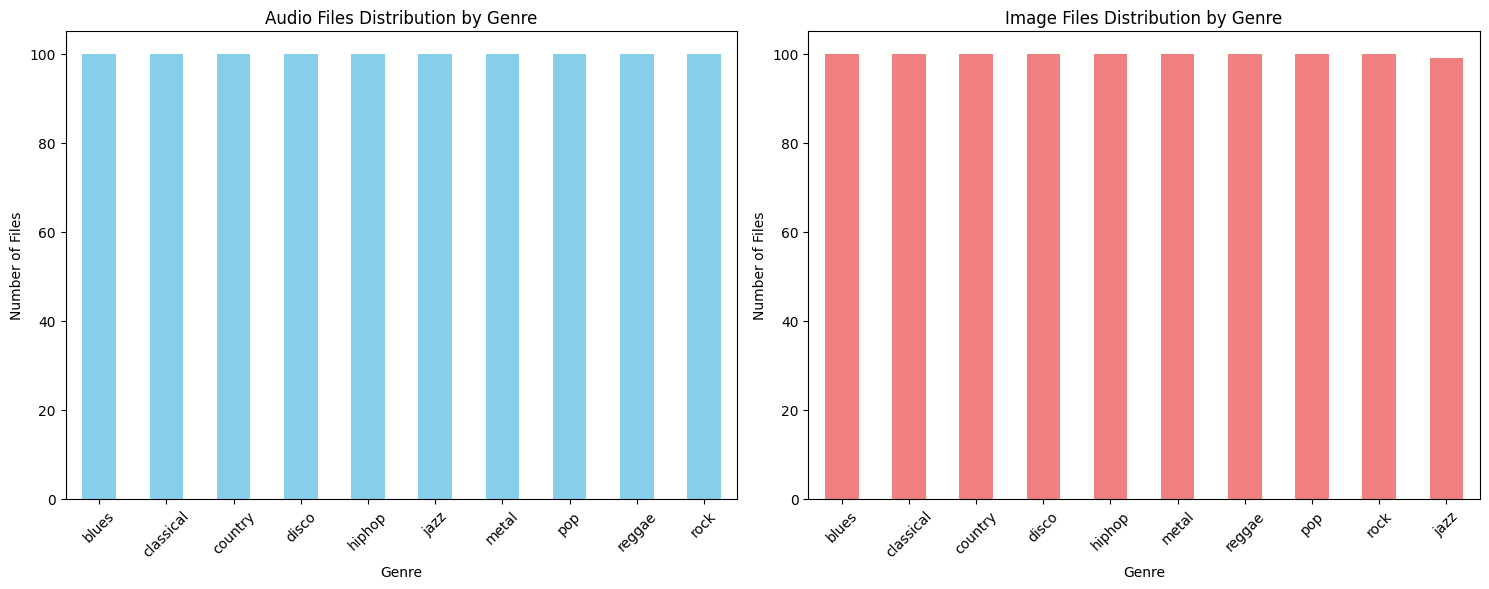


=== Example: Getting files for 'rock' genre ===
Rock audio files: 100
Rock image files: 100
First rock audio file: genres_original\rock\rock.00000.wav
First rock image file: images_original\rock\rock00000.png

=== Datasets saved ===
Files saved:
- audio_dataset.csv
- image_dataset.csv
- combined_dataset.csv

Data import completed successfully!


In [6]:
# Cell 2: Data Loading and Exploration
# Set the data directories
genres_dir = "genres_original"
images_dir = "images_original"

# Get all available genres
genres = [d for d in os.listdir(genres_dir) if os.path.isdir(os.path.join(genres_dir, d))]
print(f"Available genres: {genres}")

# Function to collect file paths and labels
def collect_data_info(data_dir, file_extension=None):
    """
    Collect file paths and labels from the data directory
    
    Args:
        data_dir (str): Path to the data directory
        file_extension (str): Optional file extension filter (e.g., '.wav', '.png')
    
    Returns:
        tuple: (file_paths, labels, genre_counts)
    """
    file_paths = []
    labels = []
    genre_counts = {}
    
    for genre in genres:
        genre_path = os.path.join(data_dir, genre)
        if os.path.exists(genre_path):
            files = os.listdir(genre_path)
            
            # Filter by file extension if provided
            if file_extension:
                files = [f for f in files if f.endswith(file_extension)]
            
            for file in files:
                file_path = os.path.join(genre_path, file)
                file_paths.append(file_path)
                labels.append(genre)
            
            genre_counts[genre] = len(files)
    
    return file_paths, labels, genre_counts

# Collect audio file information
print("\n=== Audio Files ===")
audio_files, audio_labels, audio_counts = collect_data_info(genres_dir, '.wav')
print(f"Total audio files: {len(audio_files)}")
print("Files per genre:")
for genre, count in audio_counts.items():
    print(f"  {genre}: {count} files")

# Collect image file information
print("\n=== Image Files ===")
image_files, image_labels, image_counts = collect_data_info(images_dir, '.png')
print(f"Total image files: {len(image_files)}")
print("Files per genre:")
for genre, count in image_counts.items():
    print(f"  {genre}: {count} files")

# Create DataFrames
audio_df = pd.DataFrame({
    'file_path': audio_files,
    'label': audio_labels,
    'file_type': 'audio'
})

image_df = pd.DataFrame({
    'file_path': image_files,
    'label': image_labels,
    'file_type': 'image'
})

# Combine both DataFrames
combined_df = pd.concat([audio_df, image_df], ignore_index=True)

# Display the data
print("\n=== Combined Dataset ===")
print(f"Total files: {len(combined_df)}")
print(f"Audio files: {len(audio_df)}")
print(f"Image files: {len(image_df)}")

print("\nFirst few audio files:")
print(audio_df.head())

print("\nFirst few image files:")
print(image_df.head())

print("\nDataset info:")
print(combined_df.info())

# Check for any missing values
print("\nMissing values:")
print(combined_df.isnull().sum())

# Display label distribution
print("\nLabel distribution:")
print(combined_df['label'].value_counts())

# Visualize the data distribution
plt.figure(figsize=(15, 6))

# Audio files distribution
plt.subplot(1, 2, 1)
audio_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Audio Files Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.tight_layout()

# Image files distribution
plt.subplot(1, 2, 2)
image_df['label'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Image Files Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Files')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Function to get file paths for a specific genre and type
def get_files_by_genre_and_type(genre, file_type='both'):
    """
    Get file paths for a specific genre and file type
    
    Args:
        genre (str): Genre name
        file_type (str): 'audio', 'image', or 'both'
    
    Returns:
        dict: Dictionary with file paths
    """
    if file_type == 'audio':
        return audio_df[audio_df['label'] == genre]['file_path'].tolist()
    elif file_type == 'image':
        return image_df[image_df['label'] == genre]['file_path'].tolist()
    else:  # both
        return {
            'audio': audio_df[audio_df['label'] == genre]['file_path'].tolist(),
            'image': image_df[image_df['label'] == genre]['file_path'].tolist()
        }

# Example usage
print("\n=== Example: Getting files for 'rock' genre ===")
rock_files = get_files_by_genre_and_type('rock', 'both')
print(f"Rock audio files: {len(rock_files['audio'])}")
print(f"Rock image files: {len(rock_files['image'])}")
print(f"First rock audio file: {rock_files['audio'][0] if rock_files['audio'] else 'None'}")
print(f"First rock image file: {rock_files['image'][0] if rock_files['image'] else 'None'}")

# Save the DataFrames for later use
audio_df.to_csv('audio_dataset.csv', index=False)
image_df.to_csv('image_dataset.csv', index=False)
combined_df.to_csv('combined_dataset.csv', index=False)

print("\n=== Datasets saved ===")
print("Files saved:")
print("- audio_dataset.csv")
print("- image_dataset.csv") 
print("- combined_dataset.csv")

print("\nData import completed successfully!")

In [7]:
# Cell 3: Feature Examination Utility
def examine_csv_file(file_path):
    """Examine a CSV file and print its structure"""
    print(f"\n{'='*60}")
    print(f"EXAMINING: {file_path}")
    print(f"{'='*60}")
    
    try:
        # Check file size
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # MB
        print(f"File size: {file_size:.2f} MB")
        
        # Read first few lines to understand structure
        with open(file_path, 'r') as f:
            first_lines = [f.readline().strip() for _ in range(5)]
        
        print("\nFirst 5 lines:")
        for i, line in enumerate(first_lines):
            print(f"Line {i+1}: {line[:100]}{'...' if len(line) > 100 else ''}")
        
        # Try to read with pandas
        print("\nAttempting to read with pandas...")
        df = pd.read_csv(file_path)
        
        print(f"DataFrame shape: {df.shape}")
        print(f"Columns: {len(df.columns)}")
        
        # Show first few column names
        print(f"First 10 columns: {df.columns.tolist()[:10]}")
        
        # Check data types
        print(f"\nData types:")
        print(df.dtypes.value_counts())
        
        # Check for missing values
        print(f"\nMissing values per column (first 10):")
        missing_counts = df.isnull().sum()
        print(missing_counts.head(10))
        
        # Check if there's a label column
        if 'label' in df.columns:
            print(f"\nLabel column found!")
            print(f"Unique labels: {df['label'].unique()}")
            print(f"Label distribution:")
            print(df['label'].value_counts())
        else:
            print(f"\nNo 'label' column found.")
            print("First column name:", df.columns[0])
            
            # Try to extract labels from first column
            first_col = df.iloc[:, 0]
            if first_col.dtype == 'object':
                # Check if first column contains filenames with genre info
                sample_values = first_col.head(10).tolist()
                print(f"First column sample values: {sample_values}")
                
                # Try to extract genre from filename
                if '.' in str(sample_values[0]):
                    potential_genres = [str(val).split('.')[0] for val in sample_values]
                    print(f"Potential genres from filenames: {list(set(potential_genres))}")
        
        # Show sample data
        print(f"\nFirst 3 rows (first 5 columns):")
        print(df.iloc[:3, :5])
        
        # Basic statistics for numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0:
            print(f"\nNumeric columns: {len(numeric_cols)}")
            print(f"Sample statistics for first 5 numeric columns:")
            print(df[numeric_cols[:5]].describe())
        
        return df
        
    except Exception as e:
        print(f"Error examining file: {e}")
        return None

# List of feature files to examine
feature_files = [
    "features_3_sec.csv",
    "features_30_sec.csv"
]

results = {}

for file_path in feature_files:
    if os.path.exists(file_path):
        df = examine_csv_file(file_path)
        results[file_path] = df
    else:
        print(f"\nFile not found: {file_path}")

# Summary
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")

for file_path, df in results.items():
    if df is not None:
        print(f"\n{file_path}:")
        print(f"  - Shape: {df.shape}")
        print(f"  - Columns: {len(df.columns)}")
        if 'label' in df.columns:
            print(f"  - Has labels: Yes")
            print(f"  - Classes: {len(df['label'].unique())}")
        else:
            print(f"  - Has labels: No")


EXAMINING: features_3_sec.csv
File size: 10.56 MB

First 5 lines:
Line 1: filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_ce...
Line 2: blues.00000.0.wav,66149,0.3354063630104065,0.09104829281568527,0.1304050236940384,0.0035210042260587...
Line 3: blues.00000.1.wav,66149,0.3430653512477875,0.0861465260386467,0.1126992478966713,0.00144968542736023...
Line 4: blues.00000.2.wav,66149,0.34681475162506104,0.09224288910627365,0.13200338184833527,0.00462039932608...
Line 5: blues.00000.3.wav,66149,0.3636387884616852,0.08685615658760071,0.1325647234916687,0.0024475634563714...

Attempting to read with pandas...
DataFrame shape: (9990, 60)
Columns: 60
First 10 columns: ['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var']

Data types:
float64    57
object      2
int64       1
Name: count, dtype: int64

Missing v

In [9]:
# Cell 4: Image-Based Classifier Class
class ImageBasedClassifier:
    def __init__(self, data_dir="."):
        self.data_dir = data_dir
        self.images_dir = os.path.join(data_dir, "images_original")
        
        # Get available genres
        self.genres = [d for d in os.listdir(self.images_dir) 
                      if os.path.isdir(os.path.join(self.images_dir, d))]
        print(f"Available genres: {self.genres}")
        
        # Initialize models
        self.transfer_model = None
        self.custom_cnn_model = None
        self.label_encoder = LabelEncoder()
        
    def load_and_prepare_images(self, img_size=(224, 224), max_samples_per_genre=50):
        """Load and prepare spectrogram images"""
        print("Loading and preparing spectrogram images...")
        
        image_paths = []
        labels = []
        
        for genre in self.genres:
            genre_path = os.path.join(self.images_dir, genre)
            if os.path.exists(genre_path):
                # Limit samples per genre to avoid memory issues
                img_files = [f for f in os.listdir(genre_path) if f.endswith('.png')][:max_samples_per_genre]
                
                for img_file in img_files:
                    image_paths.append(os.path.join(genre_path, img_file))
                    labels.append(genre)
        
        print(f"Total images: {len(image_paths)}")
        
        # Load and preprocess images
        images = []
        processed_labels = []
        
        print("Processing images...")
        for i, (img_path, label) in enumerate(zip(image_paths, labels)):
            try:
                # Load image
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                
                # Convert to array and normalize
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                processed_labels.append(label)
                
                if (i + 1) % 100 == 0:
                    print(f"Processed {i + 1}/{len(image_paths)} images...")
                
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
        
        # Convert to numpy arrays
        X = np.array(images)
        y = np.array(processed_labels)
        
        print(f"Processed images shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        
        return X, y
    
    def prepare_image_data(self, X, y):
        """Prepare image data for training"""
        print("Preparing image data...")
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Convert to categorical
        num_classes = len(self.label_encoder.classes_)
        y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
        y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
        
        print(f"Training set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")
        print(f"Number of classes: {num_classes}")
        
        return X_train, X_test, y_train_cat, y_test_cat
    
    def create_transfer_learning_model(self, input_shape, num_classes):
        """Create a transfer learning model using pre-trained VGG16"""
        print("Creating transfer learning model with VGG16...")
        
        # Load pre-trained VGG16
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        
        # Freeze base model layers
        for layer in base_model.layers:
            layer.trainable = False
        
        # Create new model
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        # Compile model
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print("Transfer learning model created successfully!")
        return model
    
    def create_custom_cnn_model(self, input_shape, num_classes):
        """Create a custom CNN model for image classification"""
        print("Creating custom CNN model...")
        
        model = models.Sequential([
            # Convolutional layers
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            layers.Conv2D(256, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            # Flatten and dense layers
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        # Compile model
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print("Custom CNN model created successfully!")
        return model
    
    def train_model(self, model, X_train, y_train, X_test, y_test, model_name, epochs=20):
        """Train a model with data augmentation and callbacks"""
        print(f"Training {model_name}...")
        
        # Data augmentation
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
        ]
        
        # Train model
        print(f"Training {model_name} for {epochs} epochs...")
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=16),  # Reduced batch size
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate model
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"\n{model_name} Test accuracy: {test_accuracy:.4f}")
        
        return model, history, test_accuracy
    
    def plot_training_history(self, history, model_name):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{model_name} - Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{model_name} - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_training.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Training history saved as '{model_name.lower().replace(' ', '_')}_training.png'")
    
    def evaluate_model(self, model, X_test, y_test, model_name):
        """Evaluate model performance"""
        print(f"\nEvaluating {model_name}...")
        
        # Predictions
        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"{model_name} Accuracy: {accuracy:.4f}")
        
        # Classification report
        print(f"\nClassification Report for {model_name}:")
        print(classification_report(y_true, y_pred, 
                                 target_names=self.label_encoder.classes_))
        
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Confusion matrix saved as '{model_name.lower().replace(' ', '_')}_confusion_matrix.png'")
        
        return accuracy, y_pred
    
    def run_complete_analysis(self):
        """Run the complete image-based analysis"""
        print("="*60)
        print("IMAGE-BASED MUSIC GENRE CLASSIFICATION")
        print("="*60)
        
        # Load and prepare images
        X, y = self.load_and_prepare_images(max_samples_per_genre=50)  # Limit samples for faster training
        
        if X.size == 0:
            print("No images found!")
            return None
        
        # Prepare data
        X_train, X_test, y_train, y_test = self.prepare_image_data(X, y)
        
        results = {}
        
        # 1. Transfer Learning with VGG16
        print("\n" + "="*50)
        print("APPROACH 1: TRANSFER LEARNING WITH VGG16")
        print("="*50)
        
        transfer_model = self.create_transfer_learning_model(X_train.shape[1:], y_train.shape[1])
        transfer_model, transfer_history, transfer_accuracy = self.train_model(
            transfer_model, X_train, y_train, X_test, y_test, "Transfer Learning Model", epochs=15
        )
        
        # Plot training history
        self.plot_training_history(transfer_history, "Transfer Learning Model")
        
        # Evaluate
        transfer_final_accuracy, transfer_predictions = self.evaluate_model(
            transfer_model, X_test, y_test, "Transfer Learning Model"
        )
        
        results['Transfer Learning (VGG16)'] = {
            'model': transfer_model,
            'history': transfer_history,
            'accuracy': transfer_final_accuracy,
            'predictions': transfer_predictions
        }
        
        # 2. Custom CNN
        print("\n" + "="*50)
        print("APPROACH 2: CUSTOM CNN")
        print("="*50)
        
        custom_cnn = self.create_custom_cnn_model(X_train.shape[1:], y_train.shape[1])
        custom_cnn, custom_history, custom_accuracy = self.train_model(
            custom_cnn, X_train, y_train, X_test, y_test, "Custom CNN Model", epochs=20
        )
        
        # Plot training history
        self.plot_training_history(custom_history, "Custom CNN Model")
        
        # Evaluate
        custom_final_accuracy, custom_predictions = self.evaluate_model(
            custom_cnn, X_test, y_test, "Custom CNN Model"
        )
        
        results['Custom CNN'] = {
            'model': custom_cnn,
            'history': custom_history,
            'accuracy': custom_final_accuracy,
            'predictions': custom_predictions
        }
        
        # Summary
        print("\n" + "="*60)
        print("IMAGE-BASED APPROACHES COMPLETED!")
        print("="*60)
        
        for name, result in results.items():
            print(f"{name}: {result['accuracy']:.4f}")
        
        # Find best image-based approach
        best_image_model = max(results.keys(), key=lambda k: results[k]['accuracy'])
        best_image_accuracy = results[best_image_model]['accuracy']
        
        print(f"\nBest Image-based Model: {best_image_model}")
        print(f"Best Image-based Accuracy: {best_image_accuracy:.4f}")
        
        return results

In [ ]:
# Cell 6: Complete Music Classifier Class
class CompleteMusicClassifier:
    def __init__(self, data_dir="."):
        self.data_dir = data_dir
        self.genres_dir = os.path.join(data_dir, "genres_original")
        self.images_dir = os.path.join(data_dir, "images_original")
        self.features_30sec = os.path.join(data_dir, "features_30_sec.csv")
        
        # Get available genres
        self.genres = [d for d in os.listdir(self.genres_dir) 
                      if os.path.isdir(os.path.join(self.genres_dir, d))]
        print(f"Available genres: {self.genres}")
        
        # Initialize models and results
        self.tabular_results = {}
        self.image_results = {}
        self.label_encoder = LabelEncoder()
        
    def run_tabular_approach(self):
        """Run the tabular approach"""
        print("\n" + "="*60)
        print("STEP 1: TABULAR APPROACH")
        print("="*60)
        
        # Load features
        print("Loading tabular features...")
        df = pd.read_csv(self.features_30sec)
        print(f"Loaded {df.shape[0]} samples with {df.shape[1]} features")
        
        # Extract labels from filename
        df['label'] = df.iloc[:, 0].str.split('.').str[0]
        
        # Prepare data
        X = df.drop(['label', 'filename'], axis=1, errors='ignore')
        y = df['label']
        
        # Encode labels
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        print(f"Training set: {X_train_scaled.shape}")
        print(f"Test set: {X_test_scaled.shape}")
        
        # Train models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(kernel='rbf', random_state=42)
        }
        
        for name, model in models.items():
            print(f"\nTraining {name}...")
            
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Predictions
            y_pred = model.predict(X_test_scaled)
            
            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            self.tabular_results[name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': y_pred,
                'true_labels': y_test
            }
            
            print(f"{name} Accuracy: {accuracy:.4f}")
        
        return self.tabular_results
    
    def run_image_approaches(self, max_samples_per_genre=30):
        """Run both image-based approaches"""
        print("\n" + "="*60)
        print("STEP 2: IMAGE-BASED APPROACHES")
        print("="*60)
        
        # Load and prepare images
        print("Loading spectrogram images...")
        image_paths = []
        labels = []
        
        for genre in self.genres:
            genre_path = os.path.join(self.images_dir, genre)
            if os.path.exists(genre_path):
                img_files = [f for f in os.listdir(genre_path) if f.endswith('.png')][:max_samples_per_genre]
                for img_file in img_files:
                    image_paths.append(os.path.join(genre_path, img_file))
                    labels.append(genre)
        
        print(f"Total images: {len(image_paths)}")
        
        # Load and preprocess images
        images = []
        processed_labels = []
        
        print("Processing images...")
        for i, (img_path, label) in enumerate(zip(image_paths, labels)):
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))
                img_array = np.array(img) / 255.0
                images.append(img_array)
                processed_labels.append(label)
                
                if (i + 1) % 50 == 0:
                    print(f"Processed {i + 1}/{len(image_paths)} images...")
                    
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
        
        X = np.array(images)
        y = np.array(processed_labels)
        
        print(f"Processed images shape: {X.shape}")
        
        # Prepare image data
        y_encoded = self.label_encoder.fit_transform(y)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )
        
        num_classes = len(self.label_encoder.classes_)
        y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
        y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)
        
        print(f"Training set: {X_train.shape}")
        print(f"Test set: {X_test.shape}")
        
        # 1. Transfer Learning with VGG16
        print("\n" + "="*50)
        print("APPROACH 1: TRANSFER LEARNING WITH VGG16")
        print("="*50)
        
        transfer_model = self.create_transfer_learning_model(X_train.shape[1:], num_classes)
        transfer_accuracy = self.train_and_evaluate_model(
            transfer_model, X_train, y_train_cat, X_test, y_test_cat, 
            "Transfer Learning (VGG16)", epochs=10
        )
        
        self.image_results['Transfer Learning (VGG16)'] = transfer_accuracy
        
        # 2. Custom CNN
        print("\n" + "="*50)
        print("APPROACH 2: CUSTOM CNN")
        print("="*50)
        
        custom_cnn = self.create_custom_cnn_model(X_train.shape[1:], num_classes)
        custom_accuracy = self.train_and_evaluate_model(
            custom_cnn, X_train, y_train_cat, X_test, y_test_cat, 
            "Custom CNN", epochs=15
        )
        
        self.image_results['Custom CNN'] = custom_accuracy
        
        return self.image_results
    
    def create_transfer_learning_model(self, input_shape, num_classes):
        """Create transfer learning model with VGG16"""
        print("Creating transfer learning model with VGG16...")
        
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        
        # Freeze base model layers
        for layer in base_model.layers:
            layer.trainable = False
        
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def create_custom_cnn_model(self, input_shape, num_classes):
        """Create custom CNN model"""
        print("Creating custom CNN model...")
        
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.BatchNormalization(),
            
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_and_evaluate_model(self, model, X_train, y_train, X_test, y_test, model_name, epochs=15):
        """Train and evaluate a model"""
        print(f"Training {model_name}...")
        
        # Data augmentation
        datagen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            zoom_range=0.1
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7)
        ]
        
        # Train model
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=16),
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            verbose=1
        )
        
        # Evaluate
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"{model_name} Final Accuracy: {test_accuracy:.4f}")
        
        return test_accuracy
    
    def compare_all_approaches(self):
        """Compare all approaches and create comprehensive analysis"""
        print("\n" + "="*60)
        print("COMPREHENSIVE APPROACH COMPARISON")
        print("="*60)
        
        # Collect all results
        all_results = {}
        
        # Tabular results
        for name, result in self.tabular_results.items():
            all_results[f"Tabular - {name}"] = result['accuracy']
        
        # Image results
        for name, accuracy in self.image_results.items():
            all_results[name] = accuracy
        
        # Create comparison plot
        self.create_comparison_plot(all_results)
        
        # Find best approach
        best_approach = max(all_results.keys(), key=lambda k: all_results[k])
        best_accuracy = all_results[best_approach]
        
        print(f"\n" + "="*50)
        print("FINAL RESULTS SUMMARY")
        print("="*50)
        
        print("\nAll Approaches Ranked by Accuracy:")
        sorted_results = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
        
        for i, (approach, accuracy) in enumerate(sorted_results, 1):
            print(f"{i}. {approach}: {accuracy:.4f}")
        
        print(f"\ BEST OVERALL APPROACH: {best_approach}")
        print(f" BEST ACCURACY: {best_accuracy:.4f}")
        
        # Detailed analysis
        print(f"\n" + "="*50)
        print("DETAILED ANALYSIS")
        print("="*50)
        
        # Tabular vs Image comparison
        tabular_accuracies = [acc for name, acc in all_results.items() if 'Tabular' in name]
        image_accuracies = [acc for name, acc in all_results.items() if 'Tabular' not in name]
        
        if tabular_accuracies and image_accuracies:
            avg_tabular = np.mean(tabular_accuracies)
            avg_image = np.mean(image_accuracies)
            
            print(f"Average Tabular Accuracy: {avg_tabular:.4f}")
            print(f"Average Image-based Accuracy: {avg_image:.4f}")
            
            if avg_tabular > avg_image:
                print(" Tabular approaches perform better on average")
            elif avg_image > avg_tabular:
                print(" Image-based approaches perform better on average")
            else:
                print(" Both approaches perform similarly on average")
        
        return all_results, best_approach, best_accuracy
    
    def create_comparison_plot(self, all_results):
        """Create comprehensive comparison visualization"""
        print("\nCreating comparison visualization...")
        
        # Create figure with subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Overall accuracy comparison
        approaches = list(all_results.keys())
        accuracies = list(all_results.values())
        
        bars = ax1.bar(range(len(approaches)), accuracies, 
                       color=['skyblue' if 'Tabular' in name else 'lightcoral' for name in approaches])
        ax1.set_title('All Approaches - Accuracy Comparison', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1)
        ax1.set_xticks(range(len(approaches)))
        ax1.set_xticklabels(approaches, rotation=45, ha='right')
        
        # Add value labels on bars
        for bar, acc in zip(bars, accuracies):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Approach type comparison
        approach_types = ['Tabular', 'Image-based']
        type_accuracies = [
            np.mean([acc for name, acc in all_results.items() if 'Tabular' in name]),
            np.mean([acc for name, acc in all_results.items() if 'Tabular' not in name])
        ]
        
        ax2.bar(approach_types, type_accuracies, color=['skyblue', 'lightcoral'])
        ax2.set_title('Average Accuracy by Approach Type', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Average Accuracy')
        ax2.set_ylim(0, 1)
        
        for i, acc in enumerate(type_accuracies):
            ax2.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Performance ranking
        sorted_results = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
        ranked_approaches = [name for name, _ in sorted_results]
        ranked_accuracies = [acc for _, acc in sorted_results]
        
        ax3.barh(range(len(ranked_approaches)), ranked_accuracies, 
                 color=['gold' if i == 0 else 'silver' if i == 1 else 'lightcoral' if i == 2 else 'lightgray' 
                        for i in range(len(ranked_approaches))])
        ax3.set_title('Performance Ranking', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Accuracy')
        ax3.set_yticks(range(len(ranked_approaches)))
        ax3.set_yticklabels(ranked_approaches)
        ax3.set_xlim(0, 1)
        
        # 4. Summary statistics
        ax4.axis('off')
        summary_text = f"""
        COMPREHENSIVE ANALYSIS SUMMARY
        
        Total Approaches Tested: {len(all_results)}
        
        Best Approach: {max(all_results.keys(), key=lambda k: all_results[k])}
        Best Accuracy: {max(all_results.values()):.4f}
        
        Tabular Approaches: {len([name for name in all_results.keys() if 'Tabular' in name])}
        Image-based Approaches: {len([name for name in all_results.keys() if 'Tabular' not in name])}
        
        Accuracy Range: {min(all_results.values()):.4f} - {max(all_results.values()):.4f}
        Mean Accuracy: {np.mean(list(all_results.values())):.4f}
        """
        
        ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=12,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
        
        plt.tight_layout()
        plt.savefig('complete_comparison_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Comparison visualization saved as 'complete_comparison_results.png'")
    
    def run_complete_pipeline(self):
        """Run the complete comparison pipeline"""
        print("="*80)
        print("MUSIC GENRE CLASSIFICATION - COMPLETE COMPARISON PIPELINE")
        print("="*80)
        
        # Step 1: Tabular approach
        self.run_tabular_approach()
        
        # Step 2: Image-based approaches
        self.run_image_approaches()
        
        # Step 3: Comprehensive comparison
        all_results, best_approach, best_accuracy = self.compare_all_approaches()
        
        print(f"\n" + "="*80)
        print("🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉")
        print("="*80)
        
        return {
            'all_results': all_results,
            'best_approach': best_approach,
            'best_accuracy': best_accuracy,
            'tabular_results': self.tabular_results,
            'image_results': self.image_results
        }

Available genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
MUSIC GENRE CLASSIFICATION - COMPLETE COMPARISON PIPELINE

STEP 1: TABULAR APPROACH
Loading tabular features...
Loaded 1000 samples with 60 features
Training set: (800, 58)
Test set: (200, 58)

Training Random Forest...
Random Forest Accuracy: 0.7750

Training SVM...
SVM Accuracy: 0.7350

STEP 2: IMAGE-BASED APPROACHES
Loading spectrogram images...
Total images: 300
Processing images...
Processed 50/300 images...
Processed 100/300 images...
Processed 150/300 images...
Processed 200/300 images...
Processed 250/300 images...
Processed 300/300 images...
Processed images shape: (300, 224, 224, 3)
Training set: (240, 224, 224, 3)
Test set: (60, 224, 224, 3)

APPROACH 1: TRANSFER LEARNING WITH VGG16
Creating transfer learning model with VGG16...
Training Transfer Learning (VGG16)...
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.0750 - loss: 2.5015 - val_accuracy:

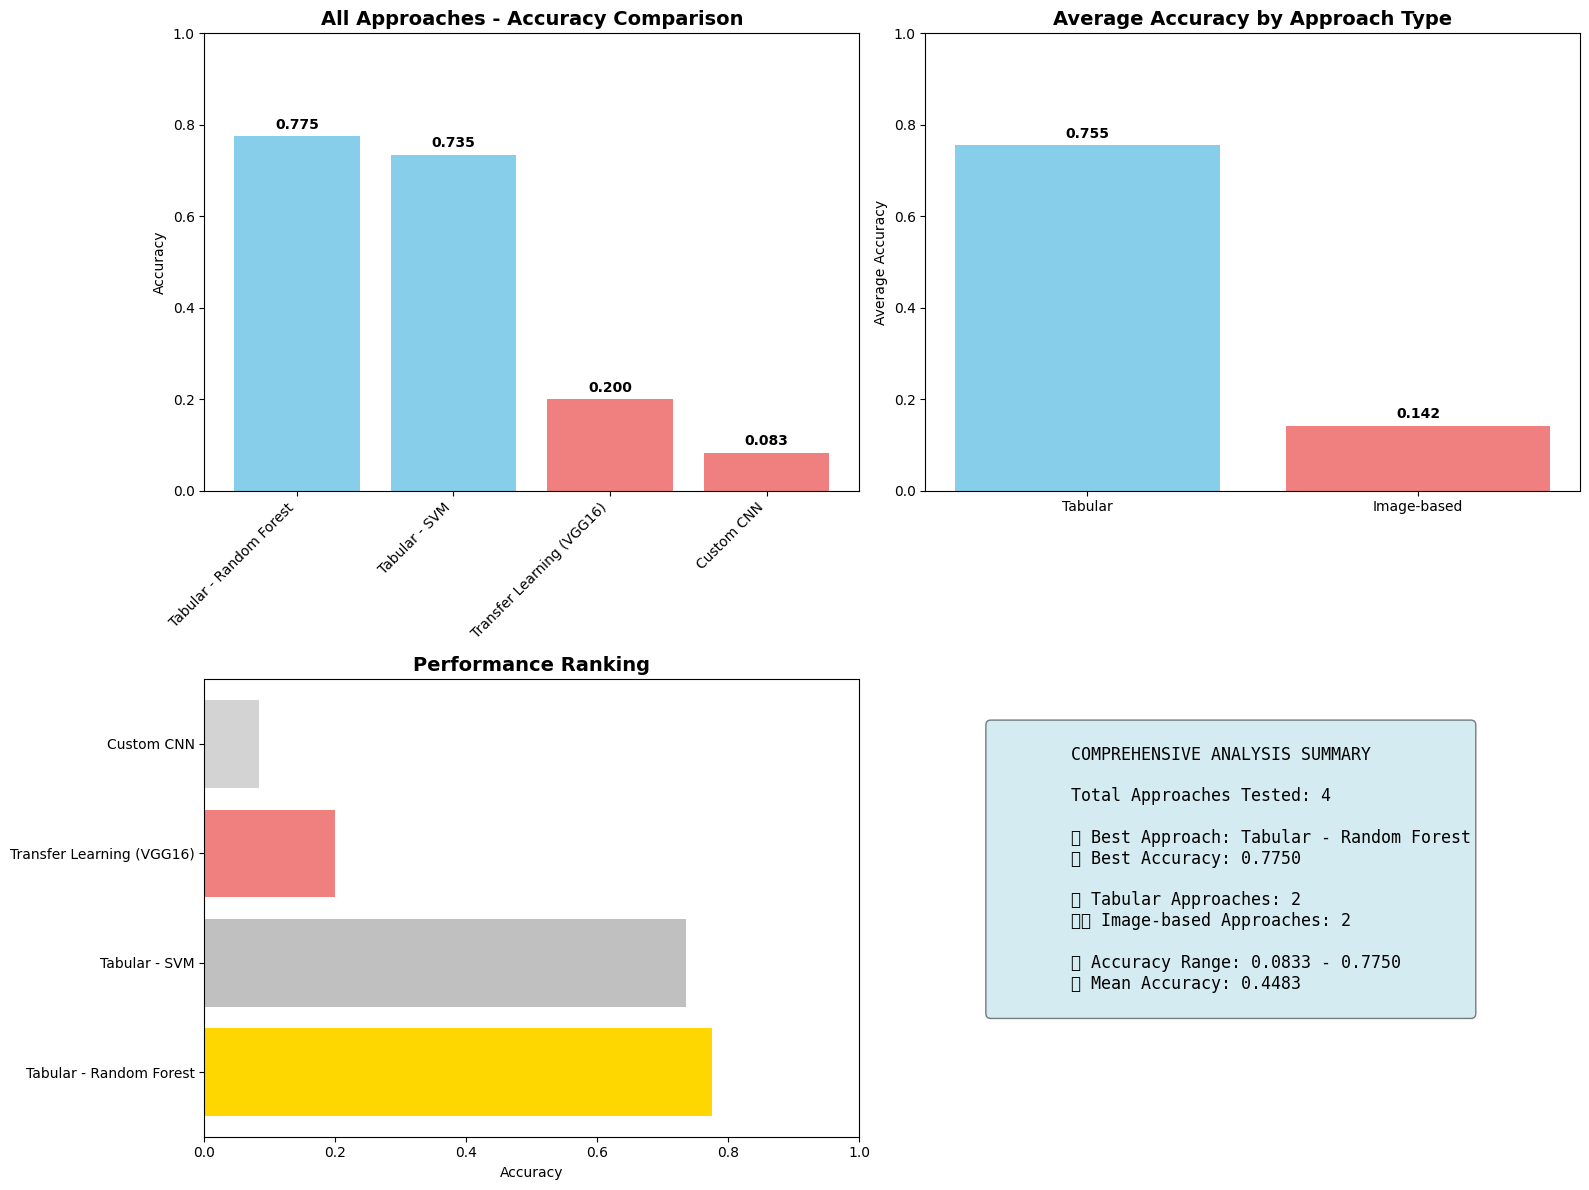

Comparison visualization saved as 'complete_comparison_results.png'

FINAL RESULTS SUMMARY

All Approaches Ranked by Accuracy:
1. Tabular - Random Forest: 0.7750
2. Tabular - SVM: 0.7350
3. Transfer Learning (VGG16): 0.2000
4. Custom CNN: 0.0833

🏆 BEST OVERALL APPROACH: Tabular - Random Forest
🏆 BEST ACCURACY: 0.7750

DETAILED ANALYSIS
Average Tabular Accuracy: 0.7550
Average Image-based Accuracy: 0.1417
📊 Tabular approaches perform better on average

🎉 PIPELINE COMPLETED SUCCESSFULLY! 🎉

Final comprehensive results: {'all_results': {'Tabular - Random Forest': 0.775, 'Tabular - SVM': 0.735, 'Transfer Learning (VGG16)': 0.20000000298023224, 'Custom CNN': 0.0833333358168602}, 'best_approach': 'Tabular - Random Forest', 'best_accuracy': 0.775, 'tabular_results': {'Random Forest': {'model': RandomForestClassifier(random_state=42), 'accuracy': 0.775, 'predictions': array([1, 0, 3, 5, 0, 9, 9, 2, 4, 5, 0, 0, 8, 0, 9, 3, 8, 5, 3, 2, 2, 8,
       0, 2, 0, 1, 7, 7, 5, 5, 3, 9, 5, 4, 5, 6, 9, 4

In [11]:
# Cell 7: Run Complete Comparison
# Initialize and run the complete comparison
complete_classifier = CompleteMusicClassifier()
complete_results = complete_classifier.run_complete_pipeline()

print(f"\nFinal comprehensive results: {complete_results}")